Title: **Assignment 2 - COSC3013 Computational Machine Learning - End-to-end Machine Learning Project**

Student ID: **S3979613**

Student Name and email (contact info): **Dao Sy Trung Kien - S3979613@rmit.edu.vn**

Affiliations: **RMIT University Vietnam.**

Date of Report: 03/08/2023

I certify that this is all my own original work. If I took any parts from elsewhere, then they were non-essential parts of the assignment, and they are clearly attributed in my submission.  I will show I agree to this honor code by typing "Yes": Yes.

Please start your report here. 

### Required Libraries and Utilities

In [95]:
# Importing packages - Pandas, Numpy, Seaborn, Scipy, Impute
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
np.random.seed(0)
from sklearn.impute import SimpleImputer

# Modelling
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Oversampling
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

### Import data and check for null values.

In [96]:
# Code for import data from Paitients_Files_Train csv file
df_train = pd.read_csv(r'C:\Users\Kien\Downloads\Computational ML\UCI-electricity\UCI-electricity\UCI_data.csv')
# Print out data.
df_train.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,...,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,...,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,...,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
3,2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,...,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
4,2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,...,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


In [97]:
# Calculating the Missing Values % contribution in Train Data
df_train_null = round(100*(df_train.isnull().sum())/len(df_train), 2)
df_train_null

date             0.0
T1               0.0
RH_1             0.0
T2               0.0
RH_2             0.0
T3               0.0
RH_3             0.0
T4               0.0
RH_4             0.0
T5               0.0
RH_5             0.0
T6               0.0
RH_6             0.0
T7               0.0
RH_7             0.0
T8               0.0
RH_8             0.0
T9               0.0
RH_9             0.0
T_out            0.0
Press_mm_hg      0.0
RH_out           0.0
Windspeed        0.0
Visibility       0.0
Tdewpoint        0.0
rv1              0.0
rv2              0.0
TARGET_energy    0.0
dtype: float64

### Basic Data Exploration.

In [98]:
# Check the dimensions of the Training dataset
print(df_train.shape)

(19735, 28)


In [99]:
# Get info of the dataframe columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9             19735 non-null  float64
 18  RH_9  

### Data Pre-processing.

In [100]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
Q1 = df_train.select_dtypes(include=[float, int]).quantile(0.25)
Q3 = df_train.select_dtypes(include=[float, int]).quantile(0.75)

# Calculate IQR for each column
IQR = Q3 - Q1

# Determine the lower and upper caps
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR

# Create a boolean mask for rows within the lower and upper caps
mask = ((df_train.select_dtypes(include=[float, int]) >= lower_cap) & 
        (df_train.select_dtypes(include=[float, int]) <= upper_cap)).all(axis=1)

# Filter the DataFrame using the mask
df_train_filtered = df_train[mask]

In [101]:
# plt.figure(figsize=(15, 10))
# df_train_filtered.boxplot()
# plt.title('Box plot of numerical features after handling outliers')
# plt.xticks(rotation=45)
# plt.show()

In [102]:
# Calculate the median of the Windspeed column
median_windspeed = df_train_filtered['Windspeed'].median()
# Replace missing values with median
df_train_filtered['Windspeed'].replace(0, median_windspeed, inplace=True)

### Feature Engineering.

In [103]:
# Convert the datetime column to a pandas datetime object
df_train_filtered['datetime'] = pd.to_datetime(df_train_filtered['date'])

# Create new columns for date and time
df_train_filtered['date'] = df_train_filtered['datetime'].dt.date
df_train_filtered['time'] = df_train_filtered['datetime'].dt.time

#Hour of the Day
df_train_filtered['hour'] = df_train_filtered['datetime'].dt.hour

# Day Part
df_train_filtered['day_part'] = pd.cut(df_train_filtered['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

# Season
df_train_filtered['month'] = df_train_filtered['datetime'].dt.month
df_train_filtered['season'] = df_train_filtered['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')

# Drop the original datetime column if no longer needed
df_train_filtered.drop('datetime', axis=1, inplace=True)

In [104]:
# Encode the 'day_part' categorical feature into numerical values
df_train_filtered['day_part_encoded'] = df_train_filtered['day_part'].cat.codes

In [105]:
season_to_number = {
    "Spring": 1,
    "Summer": 2,
    "Fall": 3,
    "Winter": 4
}
df_train_filtered['season_encode'] = df_train_filtered['season'].map(season_to_number)

In [106]:
temperature_columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']
df_train_filtered['temperature_mean'] = df_train_filtered[temperature_columns].mean(axis=1)

In [107]:
humidity_columns = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']
df_train_filtered['humidity_mean'] = df_train_filtered[humidity_columns].mean(axis=1)

In [108]:
df_train_filtered['daylight'] = df_train_filtered['hour'].between(6,18)
df_train_filtered['daylight'] = np.where(df_train_filtered['daylight'], 1, 0)

In [109]:
# need create hot day/ cold day 
df_train_filtered

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,time,hour,day_part,month,season,day_part_encoded,season_encode,temperature_mean,humidity_mean,daylight
0,2016-04-19,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,...,20:30:00,20,Evening,4,Spring,3,1,19.992063,36.437989,0
1,2016-03-05,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,...,04:40:00,4,Night,3,Spring,0,1,17.220741,43.398148,0
2,2016-03-14,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,...,12:40:00,12,Afternoon,3,Spring,2,1,19.015556,36.403796,1
3,2016-01-22,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,...,15:30:00,15,Afternoon,1,Winter,2,4,15.616111,45.930556,1
4,2016-02-10,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,...,00:40:00,0,Night,2,Winter,0,4,18.829630,48.865000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19726,2016-01-16,23.290000,39.126667,22.100000,38.200000,22.463333,43.296667,21.000000,41.170000,18.890000,...,20:50:00,20,Evening,1,Winter,3,4,18.607407,47.771481,0
19727,2016-04-27,20.926667,34.700000,19.633333,34.766667,21.200000,34.026667,20.500000,33.651111,19.066667,...,16:40:00,16,Afternoon,4,Spring,2,1,18.860116,34.789677,1
19730,2016-01-27,20.100000,44.900000,19.390000,44.172500,19.700000,44.000000,19.066667,46.466667,17.611111,...,06:30:00,6,Morning,1,Winter,1,4,17.705679,52.020525,1
19731,2016-04-14,21.390000,41.090000,19.230000,44.633333,22.790000,38.030000,22.533333,39.360000,20.390000,...,08:50:00,8,Morning,4,Spring,1,1,19.867315,42.632885,1


### Correlation Matrix

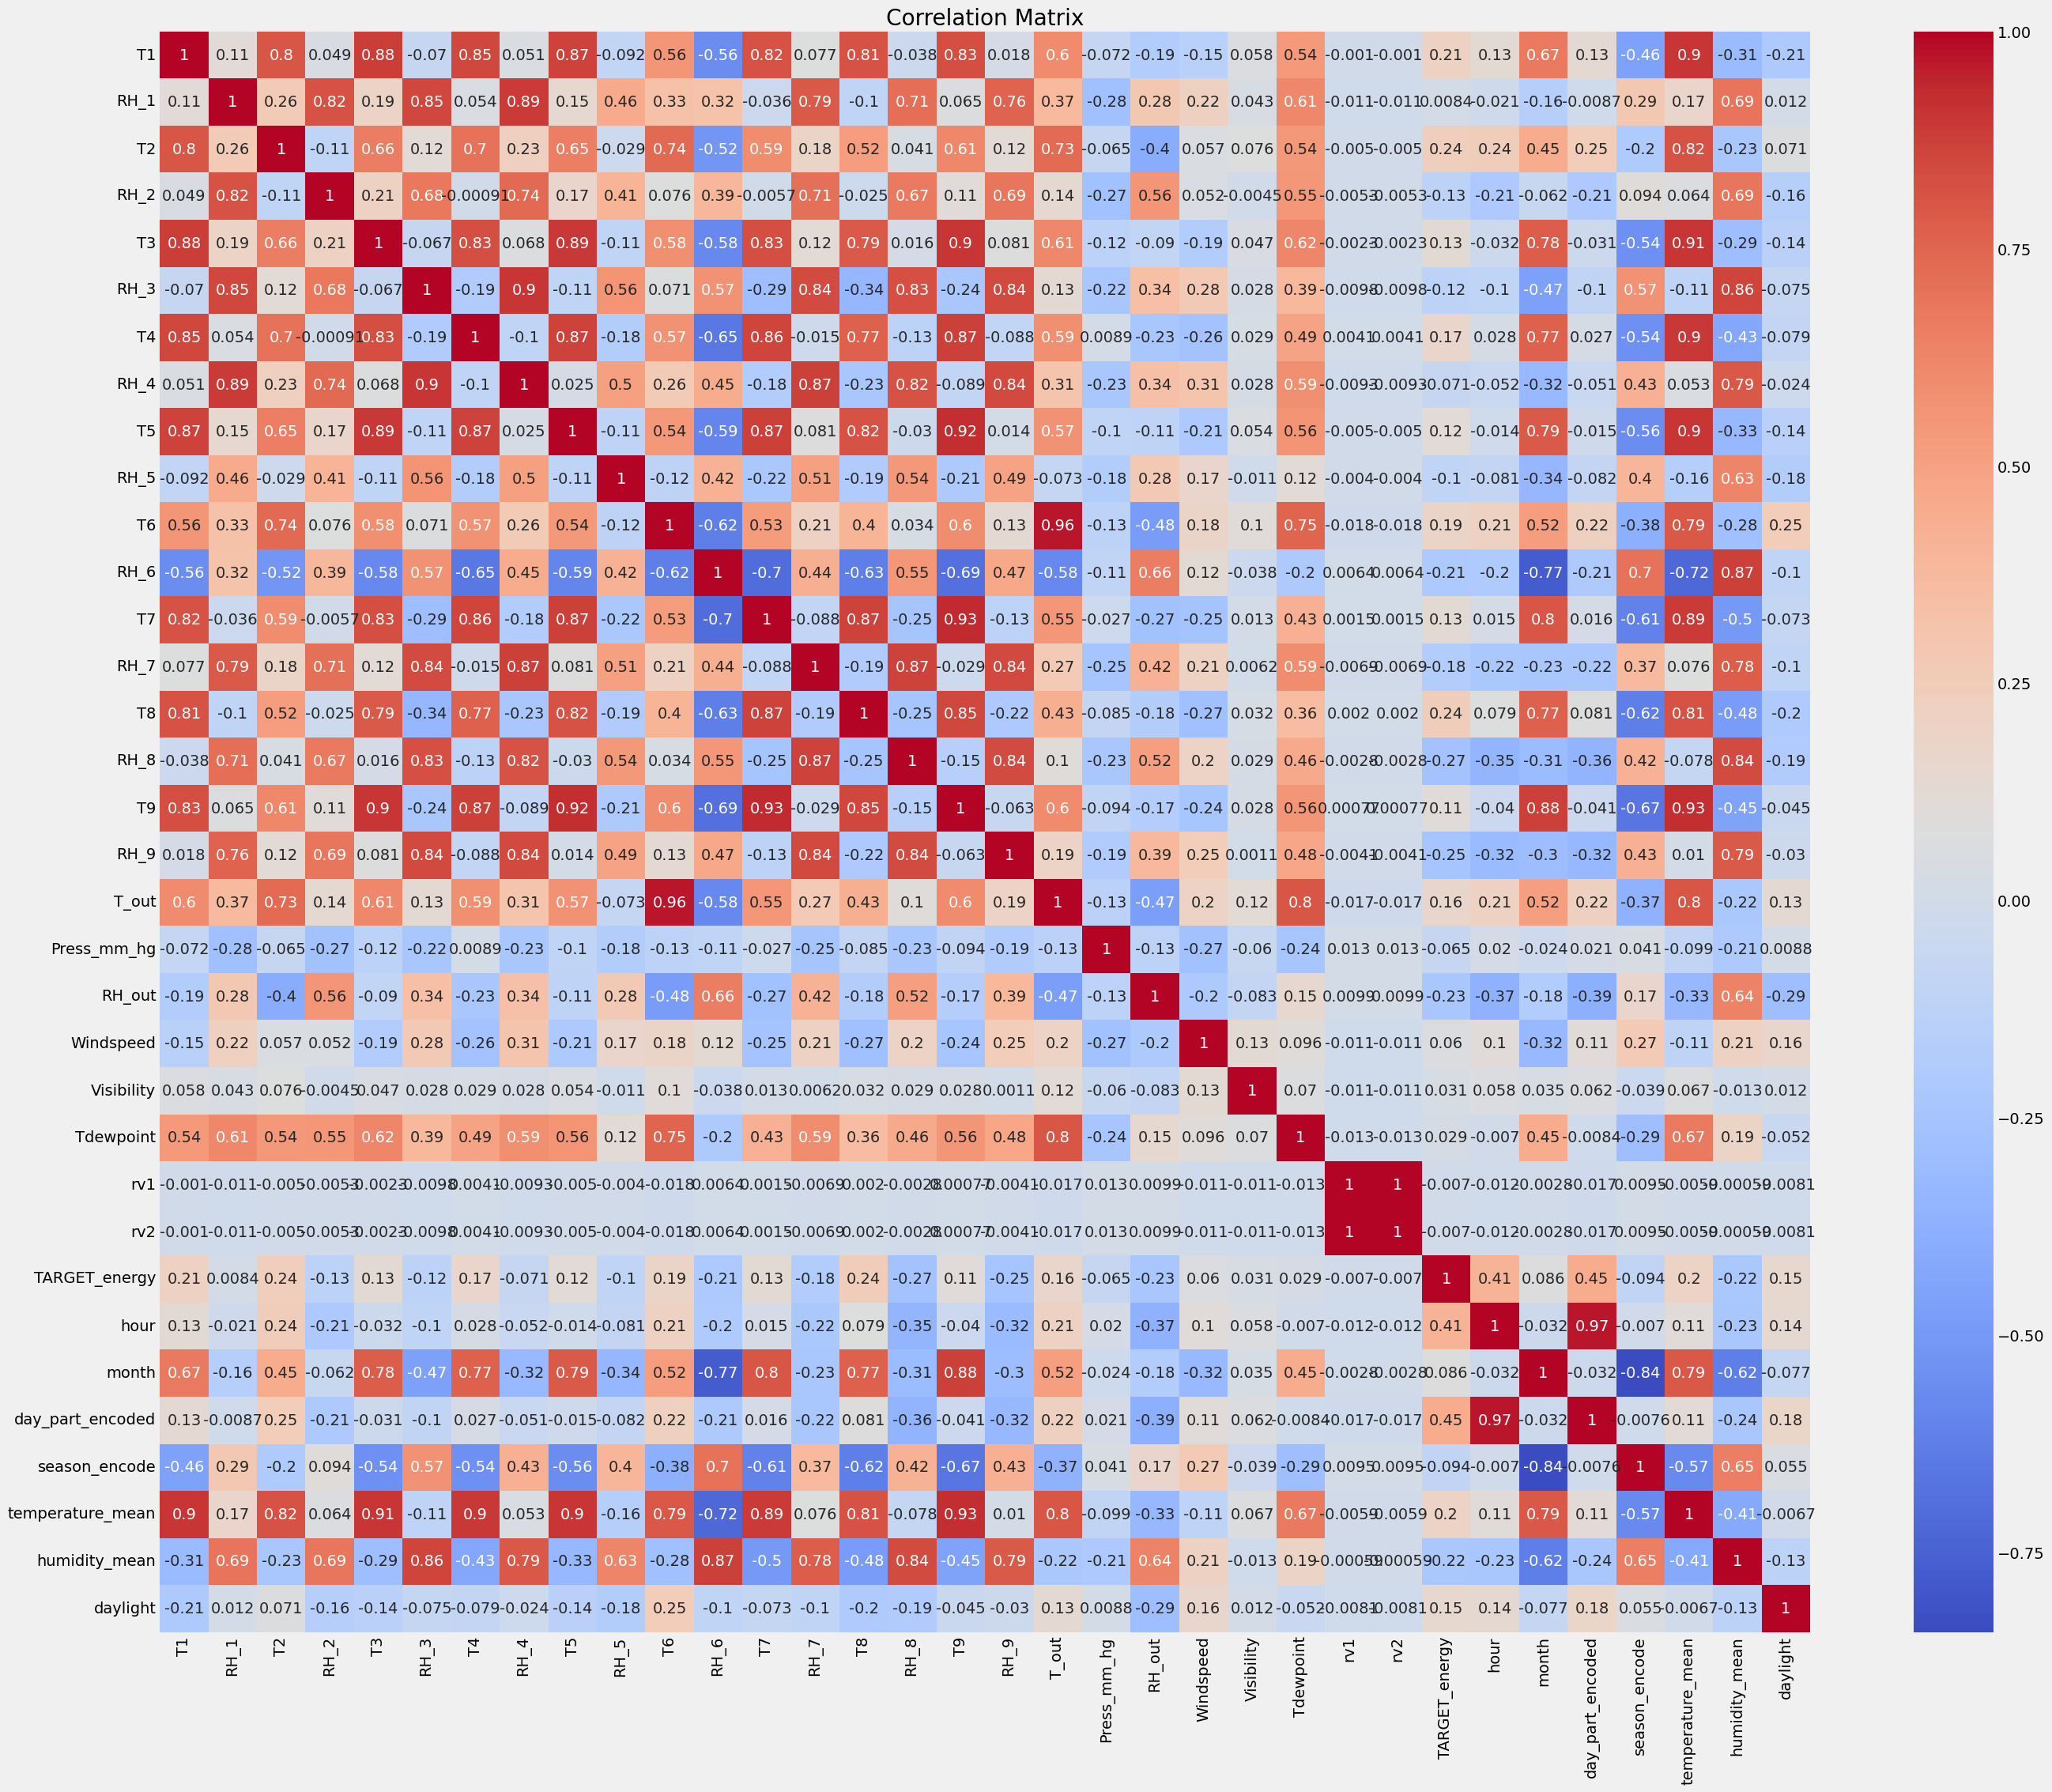

In [110]:
# Correlation Matrix
numeric_df_train = df_train_filtered.select_dtypes(include=[np.number])
plt.figure(figsize=(30, 25))
sns.heatmap(numeric_df_train.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Data Modeling

In [111]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'humidity_mean', 'day_part_encoded', 'daylight', 'Windspeed', 'Visibility', 'Tdewpoint']]
y = df_train_filtered['TARGET_energy']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, shuffle=True)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean()}')

Mean Squared Error: 739.8758043267478
R^2 Score: 0.22537694055697688
Cross-validated MSE: 679.9600695569534


In [112]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'humidity_mean', 'day_part_encoded', 'daylight', 'Windspeed', 'Visibility', 'Tdewpoint']]
y = df_train_filtered['TARGET_energy']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, shuffle=True)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean()}')

Mean Squared Error: 327.6985969685192
R^2 Score: 0.656911486665082
Cross-validated MSE: 308.8816153037374
